In [1]:
import ipycanvas

training_canvas, ranks_canvas, input_domain_canvas = ipycanvas.Canvas(), ipycanvas.Canvas(), ipycanvas.Canvas()
training_canvas.width = training_canvas.height = 1000
ranks_canvas.width, ranks_canvas.height = 1600, 800
input_domain_canvas.width = input_domain_canvas.height = 600
training_canvas.font = ranks_canvas.font = input_domain_canvas.font = "30px arial"
args = ('Results will appear as processed', training_canvas.width / 4, training_canvas.height / 3)
training_canvas.fill_text(*args); ranks_canvas.fill_text(*args); input_domain_canvas.fill_text(*args)

In [2]:
training_canvas

Canvas(height=1000, width=1000)

In [3]:
ranks_canvas

Canvas(height=800, width=1600)

In [4]:
input_domain_canvas

Canvas(height=600, width=600)

In [5]:
from experiment import execute_experiment
from plots import plot_eigenspectrum_on_canvas, plot_samples_and_model_activation_on_canvas

experiment_results = execute_experiment(
    seed=12345,
    input_dimension=2,
    sample_size=5000,
    batch_size=5000,
    epochs=1000,
    learning_rate=0.05,
    hidden_units=8,
    bias=True,
    margin=0.5,
    save_models_path='./models/',
    save_experiments_path='./experiments/',
    saving_epochs_interval=100,
    plot_results_on_canvas=training_canvas,
    callbacks=[
        plot_eigenspectrum_on_canvas(ranks_canvas), 
        plot_samples_and_model_activation_on_canvas(input_domain_canvas)
    ]
)

Train accuracy: 0.3118000030517578


(-1.0, 1.0)

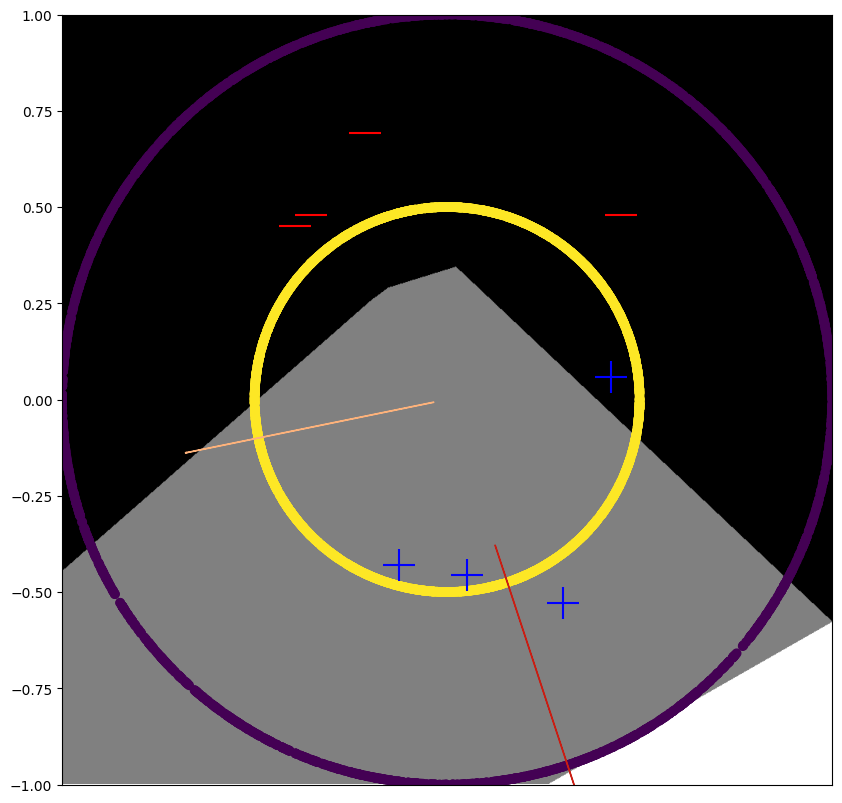

In [1]:
import numpy, torch, matplotlib.cm

from experiment import TwoLayerNeuralNet
from settings.concentric_spheres import get_dataloader
from utils.optimization import Accuracy, initialize
from plots import plot_samples_and_model_activation
from utils.persistance import parameters_from_file_path

experiment_results = dict(
    seed=12345,
    input_dimension=2,
    sample_size=5000,
    batch_size=5000,
    epochs=1000,
    learning_rate=0.05,
    hidden_units=8,
    bias=True,
    margin=0.5,
    save_models_path='./models/',
    save_experiments_path='./experiments/',
    saving_epochs_interval=100)

initialize(experiment_results['seed'])

data = get_dataloader(**experiment_results)
_, (inputs, labels) = next(enumerate(data))

model = TwoLayerNeuralNet.load('./models/', **experiment_results)
predictions = model(inputs)
print(f'Train accuracy: {Accuracy(predictions, labels)}')

fig = plot_samples_and_model_activation(data, model, experiment_results['input_dimension'])
[ax] = fig.axes

loss = torch.nn.BCEWithLogitsLoss()(predictions, labels)
loss.backward()

outer_product_d_L_d_sigma = model.dummy_variable1.grad.detach().cpu().numpy()
eigvals, eigvecs = numpy.linalg.eig(outer_product_d_L_d_sigma)
eigvals = abs(eigvals.real)
eigvecs = numpy.array(list(map(lambda x: x[1], sorted(zip(eigvals, eigvecs.real.transpose()), key=lambda x: x[0], reverse=True))))
eigvals = sorted(eigvals, reverse=True)
r_k = [sum(eigvals[k:]) / eigenvalue for k, eigenvalue in enumerate(eigvals[:-1]) if eigenvalue > 0][:-1]
k_star = r_k.index(min(r_k))

eigvecs_weights = numpy.matmul(eigvecs[:k_star], model.input_layer.weight.data.detach().cpu().numpy())
eigvecs_biases = numpy.matmul(eigvecs[:k_star], model.input_layer.bias.data.detach().cpu().numpy()).tolist()
colors = matplotlib.cm.OrRd_r(numpy.linspace(.2, .6, k_star))
for eigenvector, bias, color in zip(eigvecs_weights, eigvecs_biases, colors):
    ax.arrow(*(bias * eigenvector / numpy.linalg.norm(eigenvector)).tolist(), *eigenvector, color=color)

fig

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
#fig

In [2]:
from experiment import gradients_summary
run = {}
gradients_summary(model, summary=run)

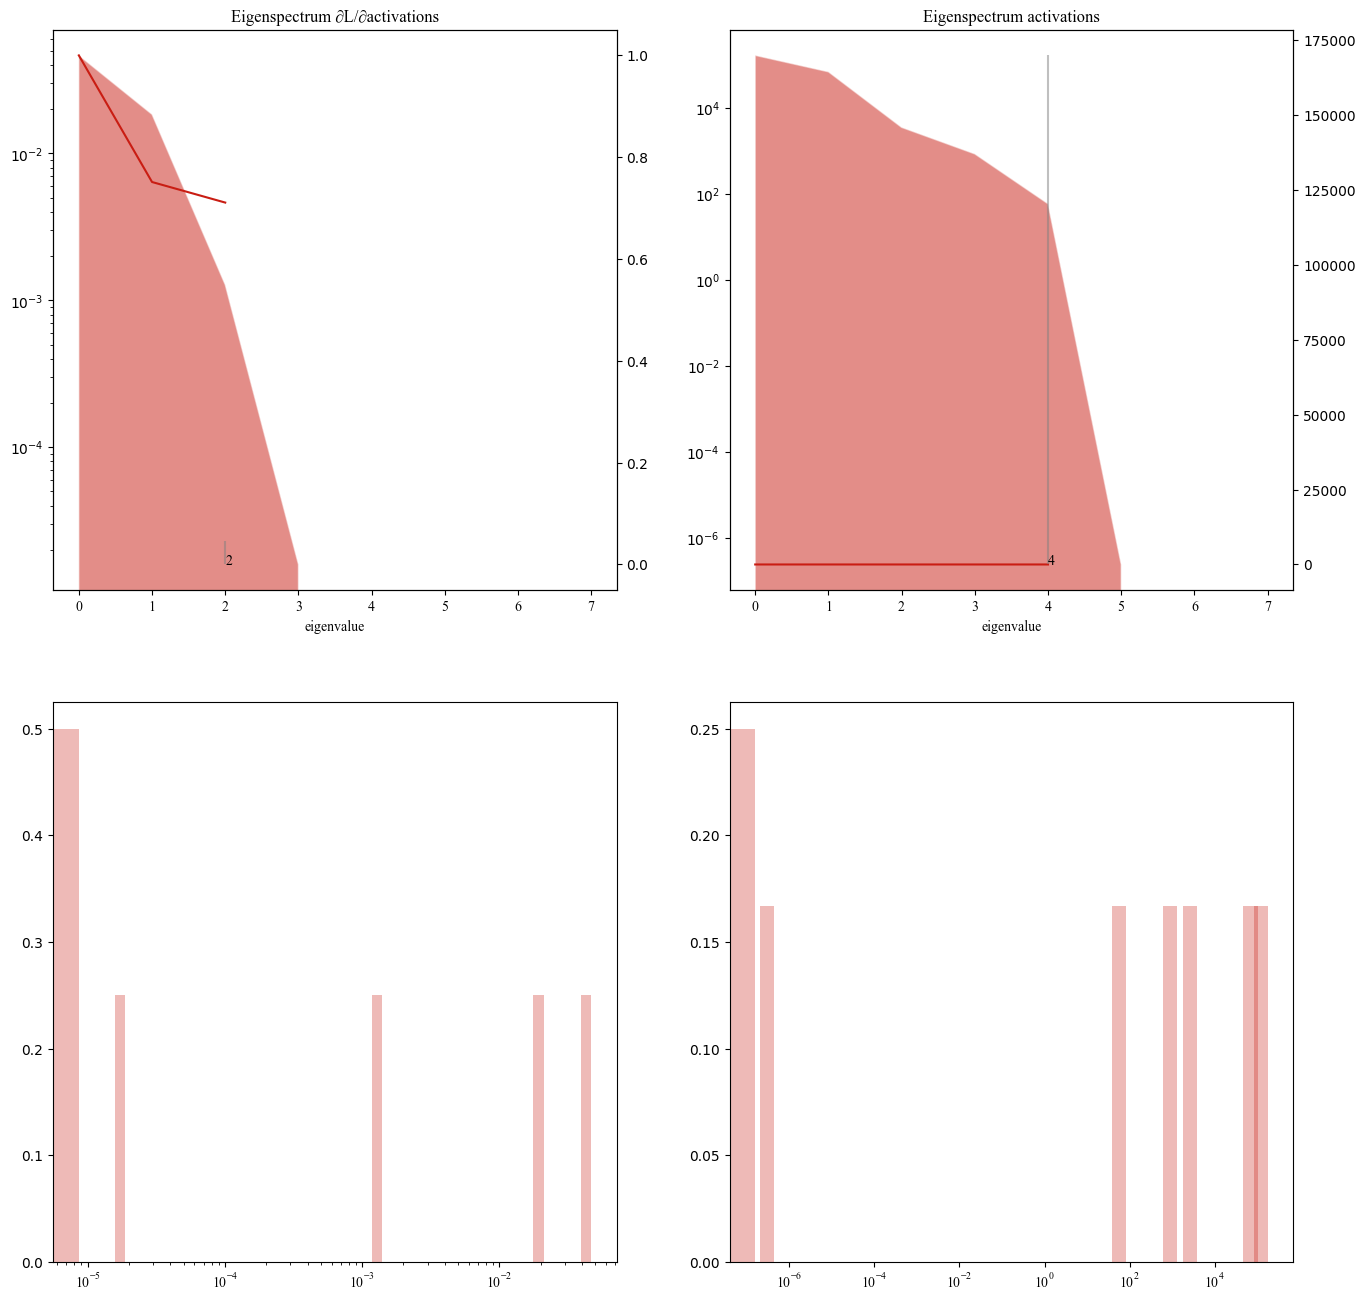

In [3]:
from plots import plot_eigenspectrum

plot_eigenspectrum(run, 0)

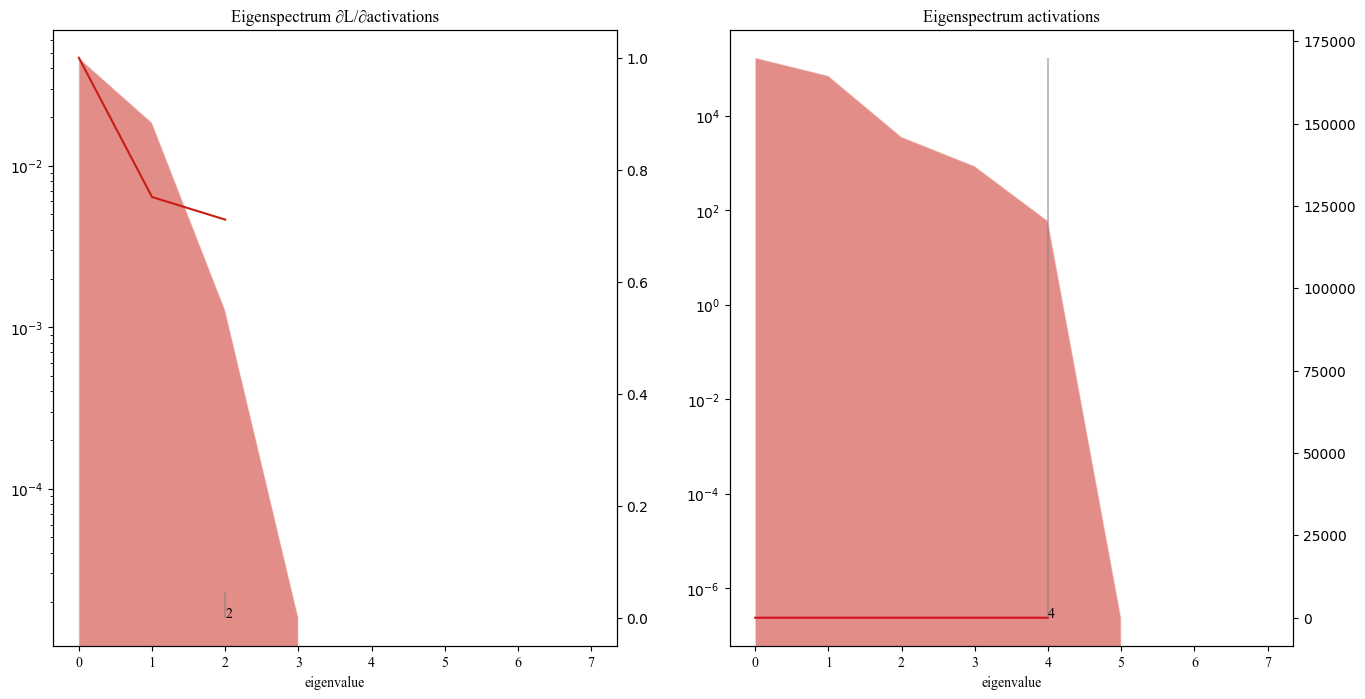

In [9]:
import matplotlib.pyplot
matplotlib.pyplot.gcf()

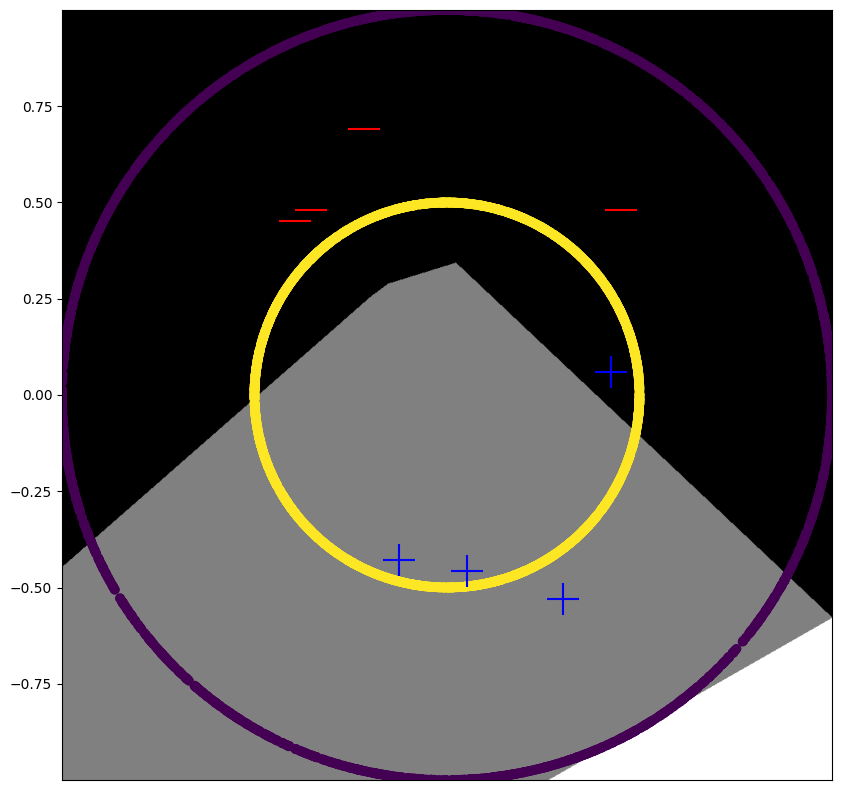

In [10]:
plot_samples_and_model_activation(data, model, experiment_results['input_dimension'])

In [11]:
model.pruning_mask = torch.concatenate([torch.ones(50), torch.zeros(68 - 50), torch.ones(100-68)])#((model.pruning_mask != torch.tensor(eigvecs[1])).long()!=torch.tensor(eigvecs[3])).long()

In [12]:
eigvecs[:10]

array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.3701565 ,
        -0.5508154 , -0.52281266, -0.5350266 ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.9073771 ,
         0.04370381,  0.3141967 ,  0.27574846],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.19870493,
         0.8152142 , -0.50082517, -0.21240604],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.01293615,
        -0.17354657, -0.61410177,  0.7698008 ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ]], dtype=float32)

In [13]:
x = numpy.linalg.norm(eigvecs, ord=0, axis=1)
eigvecs[numpy.where(x == x.min())[0]].argmax(axis=1)

array([0, 1, 2, 3])

In [14]:
eigvals

[0.046514895, 0.018443871, 0.0012754423, 1.592618e-05, 0.0, 0.0, 0.0, 0.0]